#### Copyright 2018 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# k-Means


K-Means is an *unsupervised* machine learning algorithm that can be used to group items into clusters.

So far we have only worked with supervised algorithms. Supervised algorithms have training data with labels that identify the numeric value or class for each item. These algorithms use labeled data to build a model that can be used to make predictions.

K-Means clustering is different. The training data is not labeled. Unlabeled training data is fed into the model. The model attempts to find relationships in the data and create clusters based on those relationships. Once these clusters are formed, predictions can be made about which cluster new data items belong to.

The clusters can't easily be labeled in many cases. The clusters are "emergent clusters" which are created by the algorithm and don't always map to groupings that fit our mental model.

## Overview

### Learning Objectives

* Understand the difference between supervised and unsupervised learning.
* Create a k-means model.
* Understand the output of a k-means model.

### Prerequisites

* Introduction to Colab
* Intermediate Python
* Introduction to Pandas
* Visualizations
* Introduction to scikit-learn
* Clustering

### Estimated Duration

60 minutes

### Grading Criteria

Each exercise is worth 3 points. The rubric for calculating those points is:

| Points | Description |
|--------|-------------|
| 0      | No attempt at exercise |
| 1      | Attempted exercise, but code does not run |
| 2      | Attempted exercise, code runs, but produces incorrect answer |
| 3      | Exercise completed successfully |

There are 2 exercises in this Colab so there are 6 points available. The grading scale will be 3 points.

## Clustering Example: Customer Segmentation

Let's get started by looking at a potential real world use case: customer segmentation.

Businesses often segment their customers into groups for marketing purposes. Often these segments are based on some characteristic of the customer: age, gender, spending bracket, etc. These segments are created based on assumptions that marketers have about their customers.

In this example we will use K-Means clustering to find customer segments for us instead of relying on traditional segmentation methods.


### Load the data

For this example we'll load the [Kaggle Black Friday](https://www.kaggle.com/mehdidag/black-friday#BlackFriday.csv) data. The dataset contains demographic and purchasing information about shoppers on Black Friday.

Download the `BlackFriday.csv` file and upload it to this Colab.

Now use Pandas to read the data.

In [2]:
import pandas as pd

data = pd.read_csv('./BlackFriday.csv')

data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


### Examine and clean the data

There are many useful columns of data in this data file that could be used for segmenting customers. In this case we'll ignore the common segmentation attributes (gender, age, etc.) and instead focus solely on the product categories and purchase amounts of the customers. The hope is that we can find clusters of customers based on their purchases so that we can fine tune our marketing for each cluster.

For this we'll be looking at the 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', and 'Purchase' fields.

Let's peek at the data types.


In [3]:
data.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

'Purchase' is a numeric value that contains the amount spent. The product category fields seem to be encoding a category as numeric value. 'Product_Category_1' holds ints, which fits that theory.

In [4]:
data.groupby('Product_Category_1')['Product_Category_1'].count()

Product_Category_1
1     138353
2      23499
3      19849
4      11567
5     148592
6      20164
7       3668
8     112132
9        404
10      5032
11     23960
12      3875
13      5440
14      1500
15      6203
16      9697
17       567
18      3075
Name: Product_Category_1, dtype: int64

But 'Product_Category_2' and 'Product_Category_3' contain floats instead of ints.

In [5]:
data.groupby('Product_Category_2')['Product_Category_2'].count()

Product_Category_2
2.0     48481
3.0      2835
4.0     25225
5.0     25874
6.0     16251
7.0       615
8.0     63058
9.0      5591
10.0     2991
11.0    13945
12.0     5419
13.0    10369
14.0    54158
15.0    37317
16.0    42602
17.0    13130
18.0     2730
Name: Product_Category_2, dtype: int64

Why is this? It is because some of the columns contain NaNs.

We can see from above that our valid category ranges from 1 through 18. Let's convert all of the categories to integers and just fill in invalid categories with zeros.

In [6]:
data['Product_Category_2'] = data['Product_Category_2'].fillna(0).astype(int)
data['Product_Category_3'] = data['Product_Category_3'].fillna(0).astype(int)

data.groupby('Product_Category_2')['Product_Category_2'].count()

Product_Category_2
0     166986
2      48481
3       2835
4      25225
5      25874
6      16251
7        615
8      63058
9       5591
10      2991
11     13945
12      5419
13     10369
14     54158
15     37317
16     42602
17     13130
18      2730
Name: Product_Category_2, dtype: int64

### Create Synthetic Columns

We want to be able to cluster based on the categories that customers purchased in. The current encoding makes that a little difficult. Instead of having three category columns with a number between 0 and 18 in them, let's create 18 columns with a 1 in that column if the customer purchased from the category and a 0 if they did not.

In [7]:
for i in range(1, 19):
  new_column = "PC_{}".format(i)
  data[new_column] = ((data['Product_Category_1'] == i) | (data['Product_Category_2'] == i) | (data['Product_Category_3'] == i)).astype(int)

data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,...,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18
0,1000001,P00069042,F,0-17,10,A,2,0,3,0,...,0,0,0,0,0,0,0,0,0,0
1,1000001,P00248942,F,0-17,10,A,2,0,1,6,...,0,0,0,0,0,1,0,0,0,0
2,1000001,P00087842,F,0-17,10,A,2,0,12,0,...,0,0,0,1,0,0,0,0,0,0
3,1000001,P00085442,F,0-17,10,A,2,0,12,14,...,0,0,0,1,0,1,0,0,0,0
4,1000002,P00285442,M,55+,16,C,4+,0,8,0,...,0,0,0,0,0,0,0,0,0,0


Since customers show up on more than one row of data, we need to aggregate the data by customer so that we have only one customer per row. To do this we can group by 'User_ID' and sum each category. This will give us a nice picture of how many purchases each customer made in each category.

In [8]:
aggregations = {'Purchase': 'sum'}

for i in range(1, 19):
  col = "PC_{}".format(i)
  aggregations[col] = 'sum'
  
data_by_user = data.groupby('User_ID').agg(aggregations)

data_by_user.head()

,Purchase,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18
User_ID,,,,,,,,,,,,,,,,,,,
1000001,333481,4,3,11,13,5,2,0,13,2,0,0,8,0,3,1,2,2,0
1000002,810353,31,9,0,0,15,9,0,46,1,1,2,0,3,10,7,14,7,1
1000003,341635,15,15,1,1,15,0,0,6,0,0,2,0,0,3,1,2,0,4
1000004,205987,13,4,0,0,0,1,0,2,1,0,2,0,0,2,5,3,1,0
1000005,821001,18,5,2,4,26,9,5,57,0,1,5,2,4,13,6,21,2,0


### Perform Clustering

We now have a nice data format containing purchasing information for each customer. To run k-means clustering on the data we simply load [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) from Scikit Learn and ask the model to find a specific number of clusters for us.

Notice that we are scaling the data. Our purchase total and category counts are very different in magnitude. In order not to give the purchase total too much weight we scale the values.

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

model = KMeans(n_clusters=10)
model.fit(scale(data_by_user))

print(model.inertia_)

37149.00768976177


Above we asked Scikit Learn to create 10 clusters for us and we then printed out the *inertia* for the resultant clusters. Inertia is the sum of the squared distances of samples to their closest cluster center. Typically the smaller the inertia the better.

But why did we choose 10 clusters? And is the inertia that we received reasonable?

### Find the optimal number of clusters

With just one run of the algorithm it is difficult to tell. k-means is trying to discover things about your data that you do not know. Picking a number of clusters at random isn't the best way to use k-means.

Instead, you should experiment with a few different cluster values and measure the inertia of each. As you increase the number of clusters, your inertia should decrease.

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

clusters = list(range(5, 50, 5))
inertias = []

scaled_data = scale(data_by_user)

for c in clusters:
  model = KMeans(n_clusters=c)
  model = model.fit(scaled_data)
  inertias.append(model.inertia_)

plt.plot(clusters, inertias)
plt.show()

<Figure size 640x480 with 1 Axes>

The resulting graph should start high and to the left and curve down as the number of clusters grows. The initial slope is steep, but begins to level off. Your optimal number of clusters is somewhere in the "elbow" of the graph, as the slope levels.

Once you have this number, you need to then check to see if the number is reasonable for your use case. Say that the 'optimal' number of clusters for our customer segmentation is 20. Is it reasonable to ask our marketing department to market to 20 distinct segments?

And what makes the segments distinct? We only know that specific customers clustered together. Was it due to age? Purchase price? Maybe the groups are formed on unexpected combinations such as "Bought snack food and cosmetics and spent between 100 and 150 USD". What is a good name for that segment?

Clustering the data is often just the start of your journey. Once you have clusters you'll need to look at each group and try to determine what makes them similar. What patterns did the clustering find and will it be useful to you?

## Clustering Example: Classification of Digits

Clustering for data exploration purposes can lead to interesting insights into your data, but clustering can also be used for classification purposes.

In the example below we'll try to use k-means clustering to predict handwritten digits.

### Load the data

We'll load the digits dataset packaged with Scikit Learn.

In [11]:
from sklearn.datasets import load_digits

digits = load_digits()

### Scale the data

It is a good practice to scale the data to ensure that outliers don't have too big of an impact on the clustering.

In [12]:
from sklearn.preprocessing import scale

scaled_digits = scale(digits.data)

### Fit a model

We can then create a k-means model with 10 clusters (we know there are 10 digits from 0 through 9).

In [13]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=10)
model = model.fit(scaled_digits)

### Make predictions

We can then use the model to predict which category a data point belongs to.

In the case below we'll just use some of the data that we trained with for illustrative purposes. The prediction will provide a numeric value.

In [14]:
cluster = model.predict([scaled_digits[0]])[0]

cluster

4

What is this value? Is it the predicted digit?

No, it is the cluster that the model thinks the digit belongs in. To determine the predicted digit, we'll need to see what other digits are in the cluster and choose the most popular one for our classification.


In [15]:
# Create a dictionary with the keys 0 through 9 with 0 values
label_counts = {i:0 for i in range(10)}
labels = digits.target

# Loop through all of the model labels
for i in range(len(model.labels_)):
  # If the current model label matches our predicted cluster
  if model.labels_[i] == cluster:
    # Increment the actual number
    label_counts[labels[i]] += 1

# Now find which number is the most frequent in the cluster
most_common_label = 0
for k in label_counts.keys():
  if label_counts[k] > label_counts[most_common_label]:
    most_common_label = k

print("Cluster {} prediction: {}; actual: {}".format(cluster, most_common_label, digits.target[0]))

Cluster 4 prediction: 0; actual: 0


What just happened? We reported the cluster that was predicted, the most common label in that cluster, and the actual number that was written. In this case, we see that the predicted label for the first digit was not correct, which indicates that we shouldn't be using a model with such low homogeneity and completeness scores.

### Measure model quality

If we do have labeled data, as is the case with our digits data, then we can measure the quality of our model using the [homogeneity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score_) score and the [completeness](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score) score.

In [16]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score

homogeneity = homogeneity_score(labels, model.labels_)
completeness = completeness_score(labels, model.labels_)
homogeneity, completeness

(0.598737267968926, 0.6464363637438493)

# Exercises

## Exercise 1

Load the [iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html), create a k-means model with three clusters, and find the homogeneity and completeness scores for the model. 

### Student Solution

In [17]:
# Your code goes here
from sklearn.datasets import load_iris

iris = load_iris()

from sklearn.preprocessing import scale

scaled_iris = scale(iris.data)

from sklearn.cluster import KMeans

model = KMeans(n_clusters=3)
model = model.fit(scaled_iris)

labels = iris.target

In [18]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score

homogeneity = homogeneity_score(labels, model.labels_)
completeness = completeness_score(labels, model.labels_)
homogeneity, completeness

(0.6591265018049008, 0.6598476779627759)

## Exercise 2

Load the  [iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html), create a k-means model with three clusters using only two features (try to find the best two features for clustering). Create a plot of the two features.

For each datapoint in the chart use a [marker](https://matplotlib.org/api/markers_api.html) to encode the actual/correct species. For instance use a triangle for Setosa, a square for Versicolour, and a circle for Virginica). Color each marker green if the predicted class matches the actual. Color each marker red if the classes don't match.

### Student Solution

In [19]:
# Your code goes here
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

iris = load_iris()

In [20]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = pd.Series(iris.target)

In [21]:
iris_df.dtypes

sepal length (cm)    float64
sepal width (cm)     float64
petal length (cm)    float64
petal width (cm)     float64
target                 int64
dtype: object

In [22]:
iris_petal_df = iris_df[['petal length (cm)','petal width (cm)']]

In [23]:
from sklearn.preprocessing import scale

scaled_iris = scale(iris_petal_df)

In [24]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3)
model = model.fit(scaled_iris)

In [25]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score

homogeneity = homogeneity_score(labels, model.labels_)
completeness = completeness_score(labels, model.labels_)
homogeneity, completeness

(0.8639756867013153, 0.8643954288752762)

In [26]:
model.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [27]:
# Count the most frequent numbers in each group
label1 = np.argmax(np.bincount(model.labels_[:50]))
label2 = np.argmax(np.bincount(model.labels_[50:100]))
label3 = np.argmax(np.bincount(model.labels_[100:]))
label_list = label1,label2,label3
label_list

(0, 2, 1)

In [28]:
# Relabel labels in 0 1 2 order
def relabel(x):
    if x == label_list[0]:
        return 0
    elif x == label_list[1]:
        return 1
    else:
        return 2
iris_df['predict'] = model.labels_
iris_df['predict'] = iris_df['predict'].apply(relabel)

NameError: name 'c2' is not defined

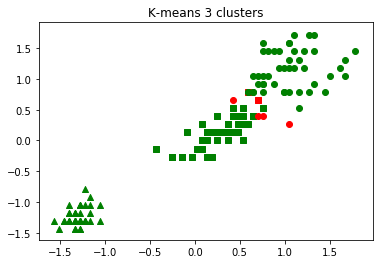

In [29]:
# Plot the identified clusters and compare with the answers
fig = plt.plot()
for i in range(0, scaled_iris.shape[0]):
  if iris_df['target'].iloc[i]== 0:
    if iris_df['predict'].iloc[i] == 0:
      c1 = plt.scatter(scaled_iris[i,0],scaled_iris[i,1],c='g',marker="^",)
    else:
      c2 = plt.scatter(scaled_iris[i,0],scaled_iris[i,1],c='r',marker="^",)
    
  elif iris_df['target'].iloc[i]== 1:
    if iris_df['predict'].iloc[i] == 1:
      c3 = plt.scatter(scaled_iris[i,0],scaled_iris[i,1],c='g',marker="s",)
    else:
      c4 = plt.scatter(scaled_iris[i,0],scaled_iris[i,1],c='r',marker="s",)
  
  elif iris_df['target'].iloc[i]== 2:
    if iris_df['predict'].iloc[i] == 2:
      c5 = plt.scatter(scaled_iris[i,0],scaled_iris[i,1],c='g',marker="o",)
    else:
      c6 = plt.scatter(scaled_iris[i,0],scaled_iris[i,1],c='r',marker="o",)

plt.title('K-means 3 clusters')
plt.legend([c1,c2,c3,c4,c5,c6],['Setosa Right','Setosa Wrong','Versicolour Right',
                                'Versicolour Wrong','Virginica Right','Virginica Wrong'],
           loc='upper left')
plt.show()
